In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import wandb

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Cross Validation

import json 
import numpy as np 
from sklearn.model_selection import StratifiedGroupKFold 

annotation = '/opt/ml/detection/dataset/train.json'

with open(annotation) as f: data = json.load(f)

var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]
X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var]) 

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411) 

In [3]:
for train_idx, val_idx in cv.split(X, y, groups): 
    print("TRAIN:", groups[train_idx])
    print(" ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print(" ", y[val_idx])

TRAIN: [   0    1    1 ... 4881 4881 4881]
  [0 3 7 ... 7 1 7]
 TEST: [   6   13   13 ... 4882 4882 4882]
  [1 6 7 ... 0 1 1]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   5    5    5 ... 4876 4876 4878]
  [7 0 0 ... 0 2 0]
TRAIN: [   0    3    3 ... 4882 4882 4882]
  [0 2 6 ... 0 1 1]
 TEST: [   1    1    1 ... 4877 4877 4880]
  [3 7 4 ... 7 7 0]
TRAIN: [   1    1    1 ... 4882 4882 4882]
  [3 7 4 ... 0 1 1]
 TEST: [   0    3    3 ... 4881 4881 4881]
  [0 2 6 ... 7 1 7]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   4    4    4 ... 4868 4872 4872]
  [1 1 1 ... 2 4 6]


In [4]:
from collections import Counter

def get_distribution(y): 
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values()) 

    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y) +1)]



distrs = [get_distribution(y)]
index = ['training set']

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)): 
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx]

    assert len(set(train_gr) & set(val_gr)) == 0 
    distrs.append(get_distribution(train_y)) 
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')
    
categories = [d['name'] for d in data['categories']] 
pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,17.14%,27.45%,3.88%,4.04%,4.24%,12.72%,5.46%,22.37%,0.69%,2.02%
train - fold0,16.96%,27.45%,3.79%,4.13%,4.48%,12.61%,5.51%,22.28%,0.77%,2.02%
val - fold0,17.85%,27.42%,4.23%,3.70%,3.26%,13.15%,5.25%,22.77%,0.35%,2.02%
train - fold1,17.14%,27.24%,4.01%,3.98%,4.28%,12.77%,5.38%,22.32%,0.67%,2.20%
val - fold1,17.12%,28.17%,3.41%,4.26%,4.12%,12.51%,5.72%,22.57%,0.73%,1.38%
train - fold2,17.31%,27.39%,3.83%,4.08%,4.13%,12.80%,5.14%,22.68%,0.69%,1.94%
val - fold2,16.42%,27.68%,4.05%,3.88%,4.70%,12.36%,6.76%,21.12%,0.69%,2.35%
train - fold3,17.30%,27.47%,3.87%,4.06%,4.22%,12.63%,5.49%,22.39%,0.63%,1.95%
val - fold3,16.50%,27.36%,3.88%,3.99%,4.33%,13.07%,5.33%,22.30%,0.92%,2.32%
train - fold4,16.97%,27.67%,3.88%,3.97%,4.10%,12.77%,5.76%,22.20%,0.68%,2.00%


In [5]:
# dataframe 생성

box_df = pd.DataFrame(data['annotations'])
box_df['x_min'] = box_df.bbox.apply(lambda x : x[0])
box_df['y_min'] = box_df.bbox.apply(lambda x : x[1])
box_df['height'] = box_df.bbox.apply(lambda x : x[2])
box_df['width'] = box_df.bbox.apply(lambda x : x[3])
box_df['x_max'] = box_df.x_min + box_df.height
box_df['y_max'] = box_df.y_min + box_df.width
box_df['ctr_x'] = box_df.x_min + box_df['height']/2
box_df['ctr_y'] = box_df.y_min + box_df['width']/2
box_df['ratio'] = box_df.height / box_df.width
box_df

,image_id,category_id,area,bbox,iscrowd,id,x_min,y_min,height,width,x_max,y_max,ctr_x,ctr_y,ratio
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,193.7,547.8,469.7,745.4,663.4,471.50,428.55,1.166276
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,407.4,57.6,180.6,57.6,588.0,28.80,497.70,0.318937
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,455.6,144.6,181.6,144.6,637.2,72.30,546.40,0.796256
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,313.4,274.3,251.9,996.6,565.3,859.45,439.35,1.088924
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,671.0,233.7,103.4,586.9,774.4,470.05,722.70,2.260155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139,0.0,116.2,944.1,814.1,944.1,930.3,472.05,523.25,1.159686
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140,302.1,439.3,265.2,216.1,567.3,655.4,434.70,547.35,1.227210
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141,511.3,451.1,58.7,30.2,570.0,481.3,540.65,466.20,1.943709
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142,255.0,421.4,271.7,195.1,526.7,616.5,390.85,518.95,1.392619


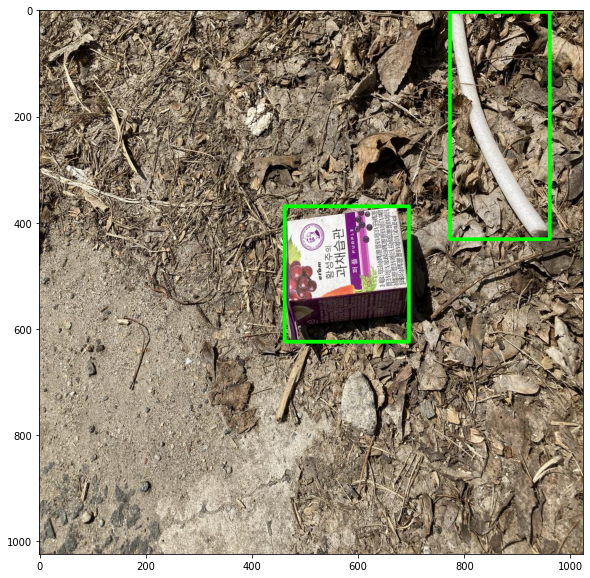

In [77]:
image_id = 3
img_root = f"detection/dataset/train/{str(image_id).zfill(4)}.jpg"
img = plt.imread(img_root)
img_bboxes = box_df[box_df.image_id == image_id]
for i in img_bboxes.index:
    x1 = int(img_bboxes['x_min'][i])
    y1 = int(img_bboxes['y_min'][i])
    x2 = int(img_bboxes['x_max'][i])
    y2 = int(img_bboxes['y_max'][i])
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5)

plt.figure(figsize=(10,10))
plt.imshow(img)

In [105]:
# category별 분포 확인

category_id = 9
box_df[box_df.category_id == category_id].describe()

,image_id,category_id,area,iscrowd,id,x_min,y_min,height,width,x_max,y_max,ctr_x,ctr_y,ratio
count,468.000000,468.0,4.680000e+02,468.0,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000
mean,2562.570513,9.0,1.893494e+05,0.0,12152.903846,335.697222,346.516026,394.682906,391.677564,730.380128,738.193590,533.038675,542.354808,1.228279
std,1346.861471,0.0,2.052086e+05,0.0,6388.894617,271.467190,244.393466,262.511220,244.472275,244.520708,228.661393,222.518248,202.646061,0.917688
min,7.000000,9.0,8.679200e+02,0.0,41.000000,0.000000,0.000000,15.200000,22.900000,35.000000,49.500000,17.500000,24.750000,0.113007
25%,1481.750000,9.0,3.924296e+04,0.0,7011.250000,106.575000,148.125000,180.700000,188.200000,552.600000,589.150000,390.050000,428.675000,0.653681
50%,2632.000000,9.0,1.180001e+05,0.0,12494.500000,266.500000,310.350000,317.650000,338.050000,789.400000,771.600000,518.250000,529.550000,0.989982
75%,3605.000000,9.0,2.577273e+05,0.0,17112.250000,520.050000,495.475000,570.475000,549.550000,935.950000,935.675000,671.587500,647.462500,1.535208
max,4858.000000,9.0,1.047962e+06,0.0,23071.000000,1004.700000,992.000000,1023.700000,1023.700000,1023.800000,1023.800000,1014.200000,1007.850000,6.623937


<AxesSubplot:title={'center':'# of trash type'}, xlabel='category_id', ylabel='count'>

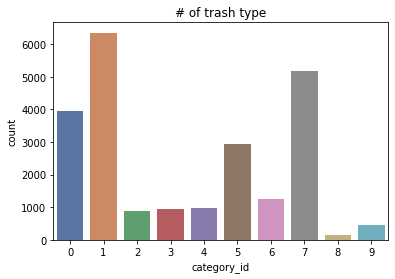

In [7]:
plt.title("# of trash type")
sns.countplot(box_df.category_id, palette = sns.color_palette('deep'))


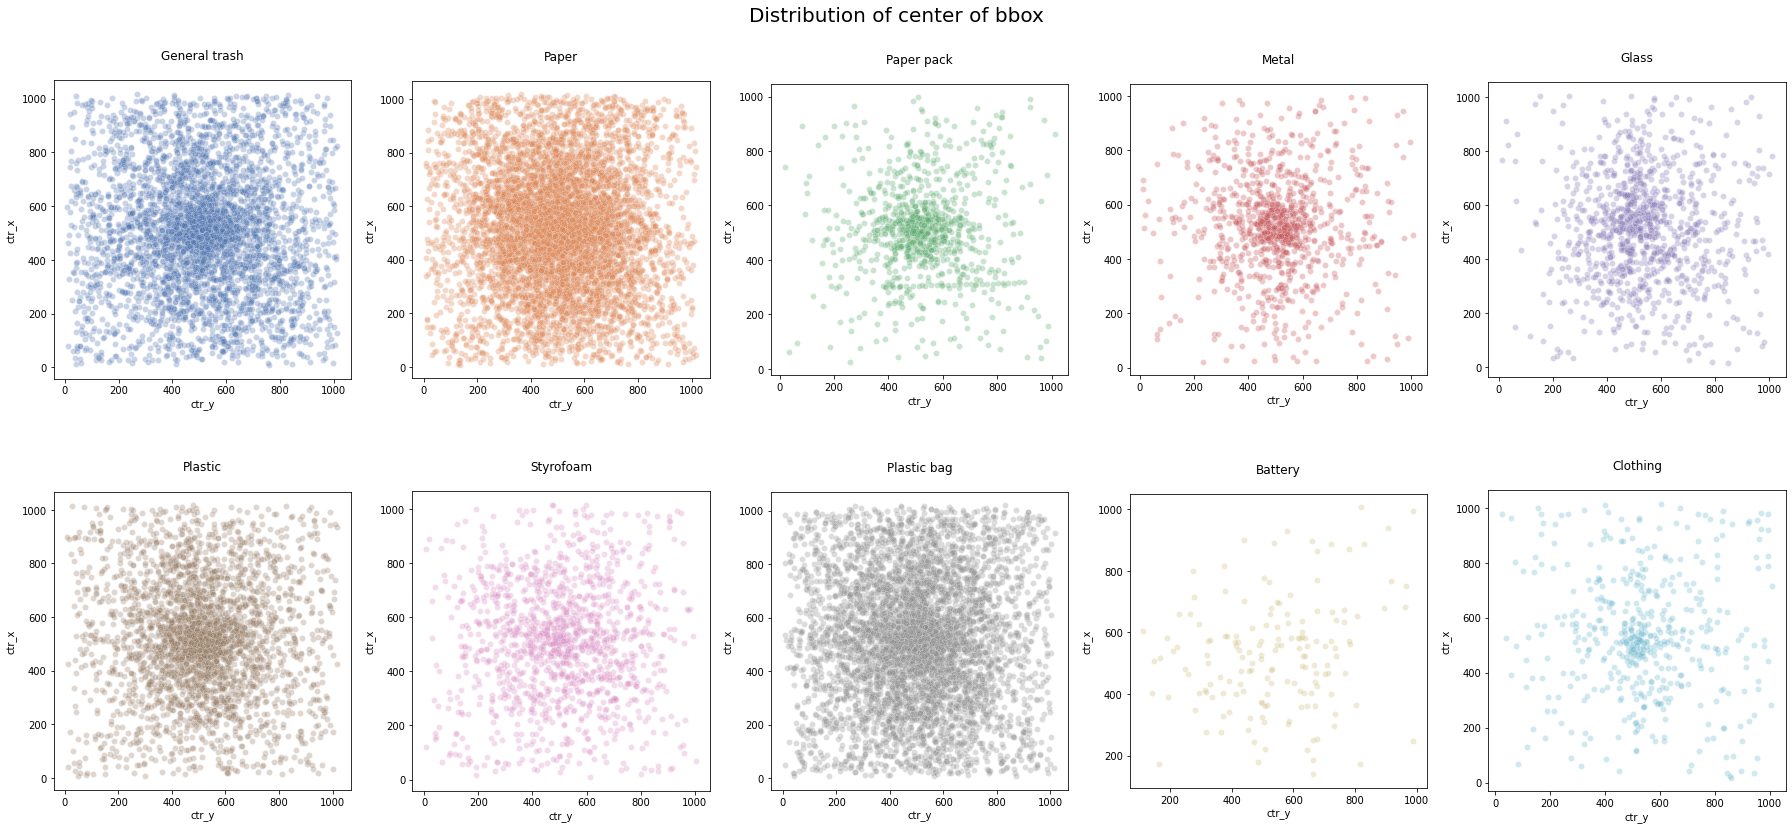

In [65]:
import seaborn as sns
categories = [d['name'] for d in data['categories']] 
color = sns.color_palette('deep')
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(25,12)
plt.suptitle("Distribution of center of bbox", fontsize =20)
for i in range(2):
    for j in range(5):
        sns.scatterplot(data = box_df[box_df.category_id == i*5+j], x= "ctr_y", y = "ctr_x", color = color[i * 5 + j], ax = axes[i][j], alpha= 0.3)
        axes[i][j].set_aspect(1)
        axes[i][j].set_title(f"{categories[i*5+j]}\n")
fig.tight_layout()

<AxesSubplot:ylabel='area'>

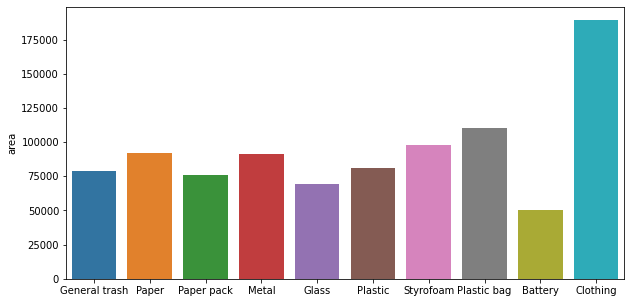

In [121]:
area_tmp = pd.DataFrame(box_df.groupby('category_id')['area'].mean())

plt.figure(figsize=(10,5))
sns.barplot(x=categories, y = area_tmp.area)

<AxesSubplot:xlabel='ratio', ylabel='Count'>

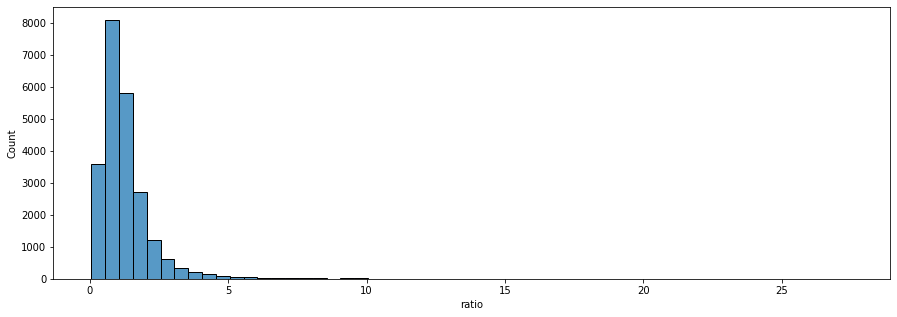

In [128]:
plt.figure(figsize=(15,5))
sns.histplot(box_df.ratio, binwidth=0.5)